# Monitoring Kiln Sensor Data

## Aim
The aim of this project is to try to determine when the insulation in a ceramic kiln is reaching the end of its life. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
plt.style.use('seaborn-dark')
%matplotlib notebook

There are nine sensors in the kiln measuring temperature data. Of these, sensor L4 is faulty.

In [2]:
cols=['L1','L2','L3','L4','L5','L6','L7','L8','L9']
good_cols=['L1','L2','L3','L5','L6','L7','L8','L9']
datadir='/home/mogmelon/Python/Projects/OnePageProjects/kiln_data/'

Set up a function to read the Excel sheets into Pandas dataframes

In [3]:
def read_excel(xls, sheet, cols, good_cols):  

    df=pd.read_excel(xls, sheet_name=sheet, index_col=0, header=0)
    df.columns=cols
    df.drop('L4', axis=1, inplace=True)
 
    df['Day'] = df.index.day
    df['Hour'] = df.index.hour
    df['Max']=df[good_cols].max(axis=1)
    df['Min']=df[good_cols].min(axis=1)
    df['Mean']=df[good_cols].mean(axis=1)
    df['Std']=df[good_cols].std(axis=1)
    df['Max_Min_Diff']=df['Max']-df['Min']
    return df

Read in two of the excel sheets

In [4]:
df1=read_excel(datadir+'K18 Data.xlsx', '6-12-19', cols, good_cols)
df2=read_excel(datadir+'K18 Data.xlsx', '24-1-20', cols, good_cols)

# Sensor Correlation
Create a heat map showing correlation between the sensors.

We can see from the heatmaps that in both datasets sensors L1, L2 and L3 (Set 1) are highly correlated with each other as are sensors L6, L7, L8 and L9 (set 2). These two sets show lower correlation between each other. 

Sensor L5 has the lowest correlation with sensors set 1 and has high correlation with sensor set 2.

All correlations are above 0.98, in general this is a good correlation. The data shows possible patterns between the sensors. 

In [5]:
def heatmap(df1, df2, cols):
    a1=df1[cols].corr()
    a2=df2[cols].corr()
    label=['Old Insulation', 'New Insulation']
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)
    for title, ax in enumerate(axes):
        sn.heatmap(a1, cmap='RdYlBu_r', ax=ax)
        ax.set_title(label[title])
    return a1, a2

<IPython.core.display.Javascript object>


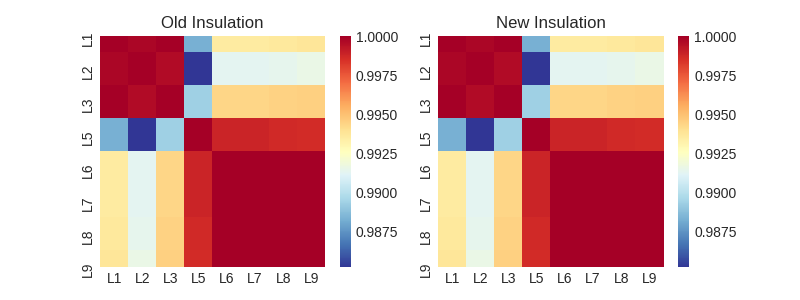

In [6]:
heatmap(df1, df2, good_cols);

# Differencing the Time Series: Creating Stationary Data

The temperature varies during heating, cooling and hold stages during the time period. This means we do not have a consistent mean value across the process. 

By differencing each data point with respect to the last point we can attempt to create a consistent mean value (stationary data). Differencing once will remove a linear trend, differencing twice will remove non-linear trends.

In the plots below we can see the raw temperature data (black) plotted against the first difference (red) in the first plot and second difference in the second plot for sensor L1. Taking the second difference creates stationary data (with the exception of a few blips). From this we can get a more accurate measure of the variance. 


In [7]:
def diff_ts(df):
    arrays={}
    for i in good_cols:
        first_diff_1=np.diff(df[i])
        second_diff_1=np.diff(first_diff_1)
        third_diff_1=np.diff(second_diff_1)
        arrays.update({i:{'1_Diff': [first_diff_1, first_diff_1.std()],
                         '2_Diff': [second_diff_1, second_diff_1.std()]}})
    return arrays

In [8]:
x1=diff_ts(df1)
x2=diff_ts(df2)

In [9]:
def plot_diff_temp(df, x, sensor, diff):
    fig, ax = plt.subplots()
    plt.plot(df.reset_index()[sensor], c='black')
    plt.title('%s, Sensor: %s' % (diff, sensor))
    ax.set_xlabel('Time')
    ax.set_ylabel('Temp')
    ax2=ax.twinx()
    ax2.plot(x[sensor][diff][0], c='red')
    ax2.set_ylabel('Diff')

<IPython.core.display.Javascript object>


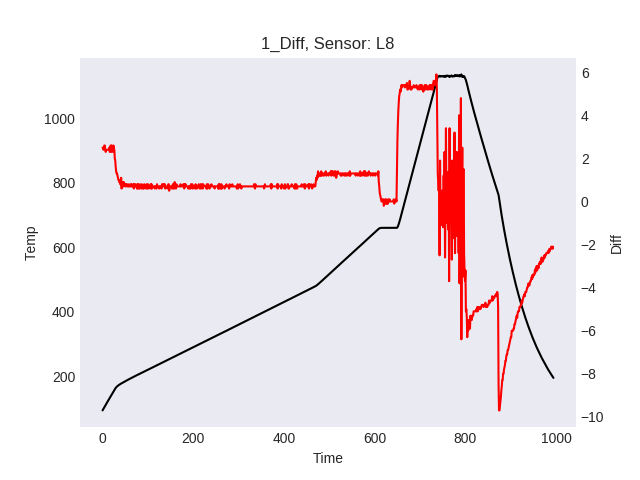

<IPython.core.display.Javascript object>


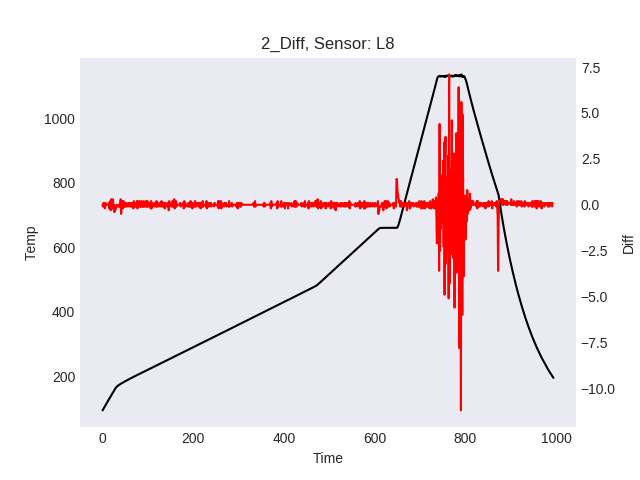

In [10]:
plot_diff_temp(df2, x2, 'L8', '1_Diff')
plot_diff_temp(df2, x2, 'L8', '2_Diff')

In [11]:
def plot_diff_ts(x, title):
    sensors=list(x.keys())
    diffs=list(x[list(sensors)[0]].keys())
    h=len(sensors)
    w=len(diffs)
    array=[x[i][j][0] for i in sensors for j in diffs]
    xlabel=diffs*h
    
    fig, axes = plt.subplots(h, w, figsize=(10, 6), sharey=True, sharex=True)
    fig.suptitle(title)
    i=0
    for ax in [plot for sub in axes for plot in sub]:   
        ax.plot(array[i])
        ax.set_ylabel(sensors[i//w])
        ax.set_xlabel(xlabel[i])  
        i+=1

The following plot shows the diffed data for all sensors

<IPython.core.display.Javascript object>


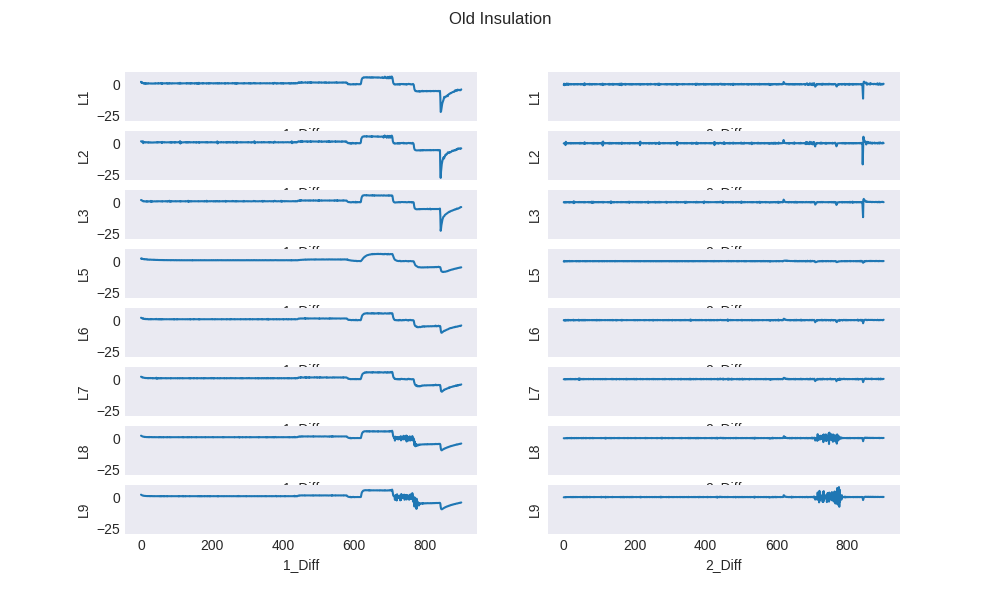

<IPython.core.display.Javascript object>


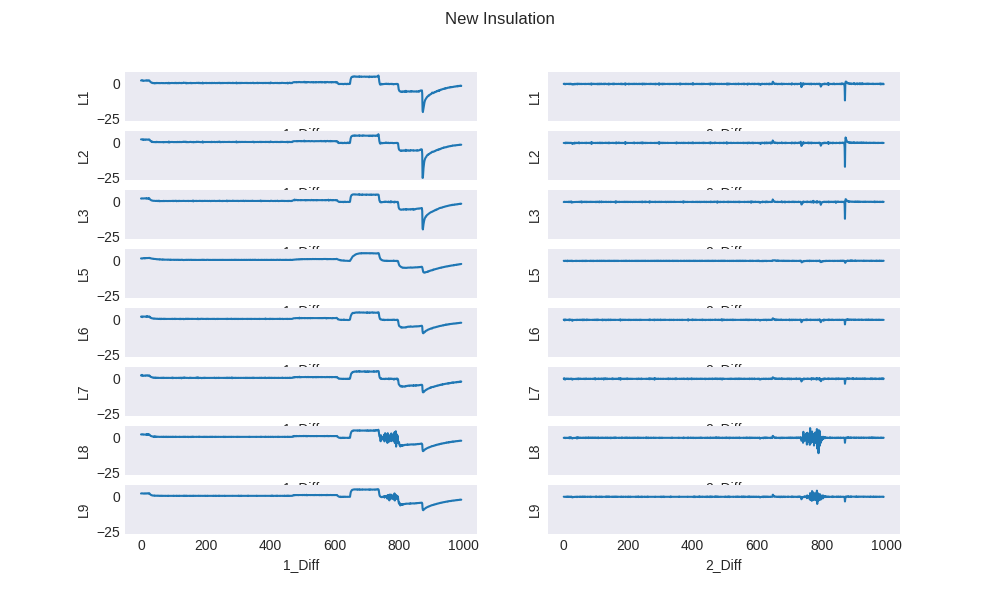

In [12]:
plot_diff_ts(x1, 'Old Insulation')
plot_diff_ts(x2, 'New Insulation')

# Variance in the Sensor Data

Looking at the standard deviation in the data, the new insulation appears to have a lower standard deviation across sensors L1, L2 and L3 compared to the old insulation. 


In [13]:
def plot_diff_std(x1, x2, diff):
    sensors=list(x1.keys())
    h=len(sensors)
    array1=[x1[i][diff][1] for i in sensors]    
    array2=[x2[i][diff][1] for i in sensors] 
    
    fig=plt.figure()
    plt.plot(array1)
    plt.plot(array2)
    locs, labels = plt.xticks()
    plt.xticks(locs[1:], labels=sensors)
    plt.ylabel('Standard Deviation')
    plt.xlabel('Sensor')
    plt.legend(['Old Insulation', 'New Insulation'])
    plt.show()

<IPython.core.display.Javascript object>


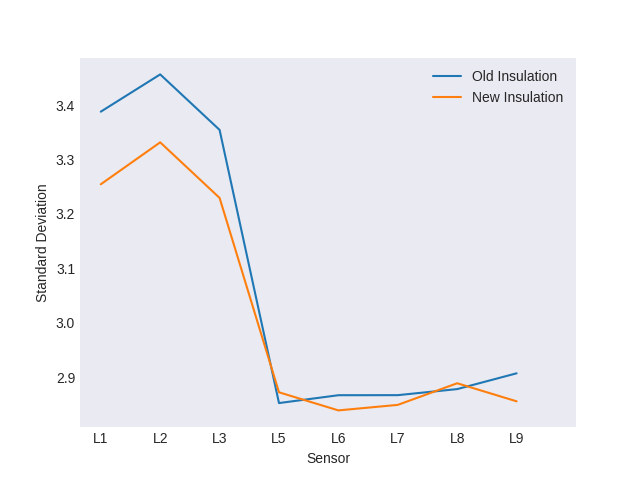

<IPython.core.display.Javascript object>


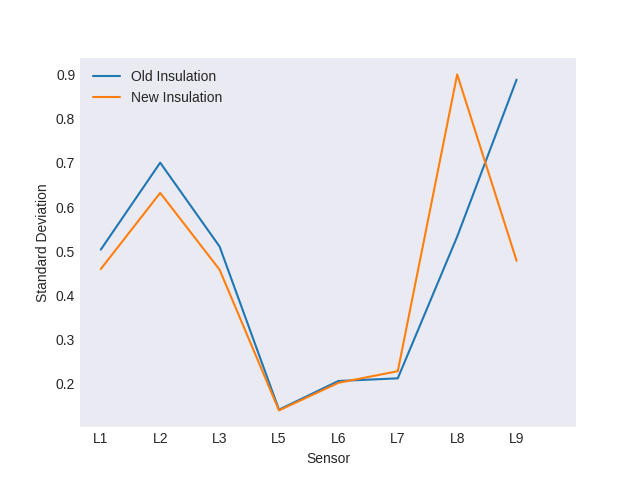

In [14]:
plot_diff_std(x1, x2, '1_Diff')
plot_diff_std(x1, x2, '2_Diff')

## Examining the Maximum Heat Zone
The following function extracts the maximum heat period and creates three plots: 
1. A scatter plot to look for correlations between sensors
2. A boxplot to examine the variation in temperature at each sensor
3. A Time series of average temperature and standard deviation across all sensors

In [15]:
def extract_heating_stage(df, cols, title='', min_T=1110, max_T=1140, scatter=True, boxplot=True, lineplot=True):
    w=len(cols)
    s=df[df[cols] > min_T][cols]
    s=s[s[cols] < max_T][cols]
    s.dropna(inplace=True)
    s['Day'] = s.index.day
    s['Hour'] = s.index.hour
    s['Max']=s[cols].max(axis=1)
    s['Min']=s[cols].min(axis=1)
    s['Mean']=s[cols].mean(axis=1)
    s['Std']=s[cols].std(axis=1)
    s['Max_Min_Diff']=s['Max']-s['Min']

    
    if scatter==True:
        pd.plotting.scatter_matrix(s[cols])
        
    if boxplot==True:
        fig, axes = plt.subplots(1, w, figsize=(10, 4), sharey=True)
        fig.suptitle(title)
        for name, ax in zip(cols, axes):
            sn.boxplot(data=s, y=name, ax=ax)
            ax.set_ylabel('Temp')
            ax.set_title(name)
            ax.set_ylim(min_T, max_T)
            #plt.tight_layout()
        #if ax != axes[-1]:
        #    ax.set_xlabel('')
        plt.show()
            
    if lineplot==True:   
        fig=plt.figure()
        plt.plot(s['Mean']) 
        plt.ylabel('Temp')
        plt.xlabel('Date')
        plt.title('Temperature showing Max/Min Range ' +title)
        plt.plot(s['Mean']-s['Std'], '--', color='grey')
        plt.plot(s['Mean']+s['Std'], '--', color='grey')
        #plt.gca().fill_between(s.index, 
         #                      s['Min'], s['Max'], 
          #                     facecolor='blue', 
           #                    alpha=0.2)
        plt.gca().fill_between(s.index, 
                               s['Mean']-s['Std'], s['Mean']+s['Std'], 
                               facecolor='grey', 
                              alpha=0.2) 
        plt.show()

<IPython.core.display.Javascript object>


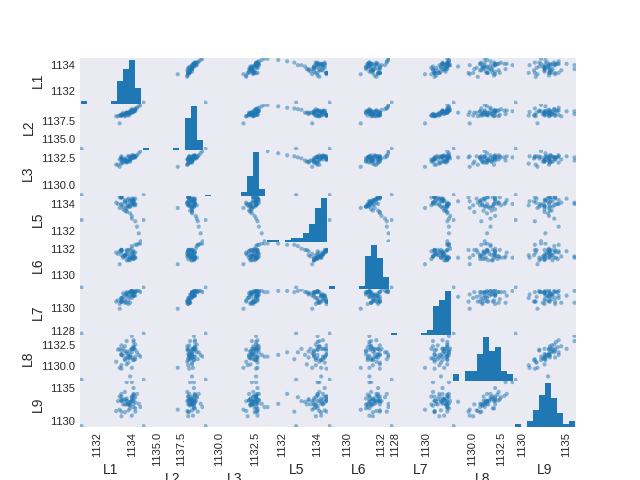

<IPython.core.display.Javascript object>


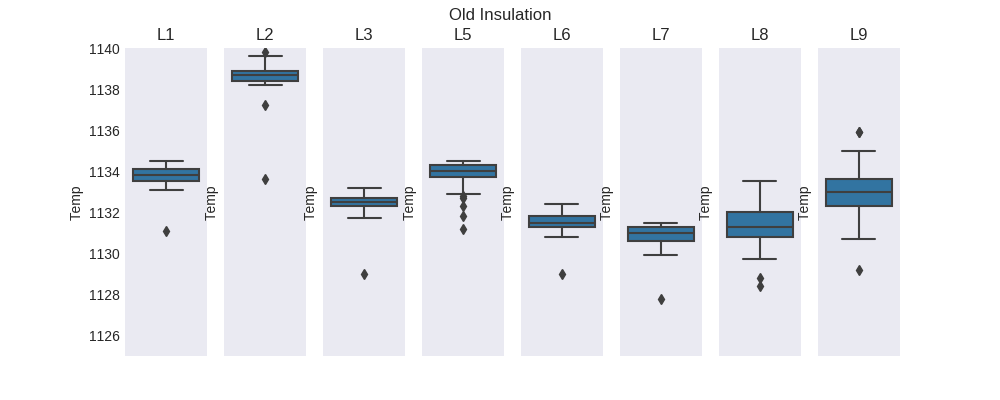

<IPython.core.display.Javascript object>


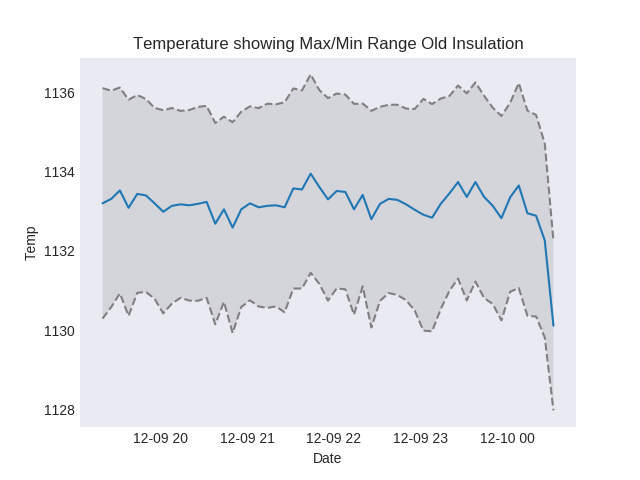

/home/mogmelon/.local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [16]:
extract_heating_stage(df1, good_cols, 'Old Insulation', max_T=1140, min_T=1125, scatter=True, boxplot=True, lineplot=True);

# Box and Whiskers Plot for the Max. Temp Zone

The final two plots show the temperature distibution in the max. heating zone across all sensors. 

<IPython.core.display.Javascript object>


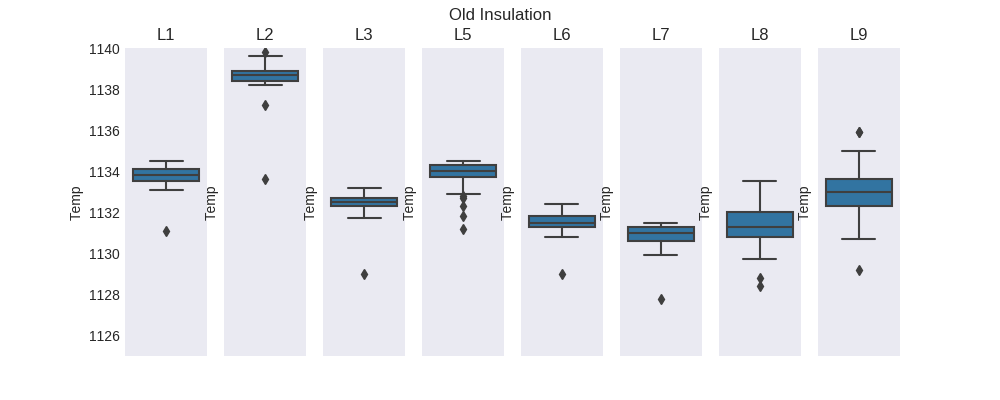

<IPython.core.display.Javascript object>


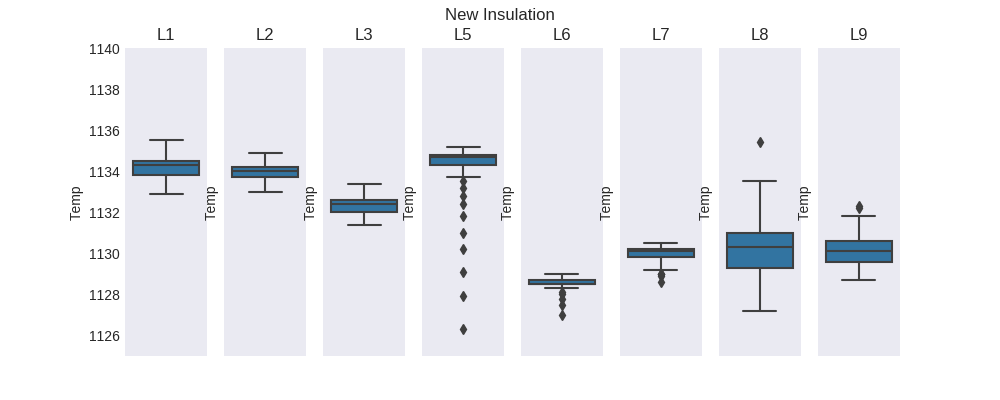

In [17]:
extract_heating_stage(df1, good_cols, 'Old Insulation', max_T=1140, min_T=1125, scatter=False, boxplot=True, lineplot=False)
extract_heating_stage(df2, good_cols, 'New Insulation', max_T=1140, min_T=1125, scatter=False, boxplot=True, lineplot=False)

## Test Ideas

In [18]:
def plot_multi_diff(x, sensors, diff):
    fig, ax = plt.subplots()
    i=0
    for sensor in sensors:
        plt.plot(x[sensor][diff][0]-i, lw=0.8, alpha=0.8)
        i+=-5
    plt.title('%s, Sensor: %s' % (diff, sensor))
    plt.legend(labels=sensors)

<IPython.core.display.Javascript object>


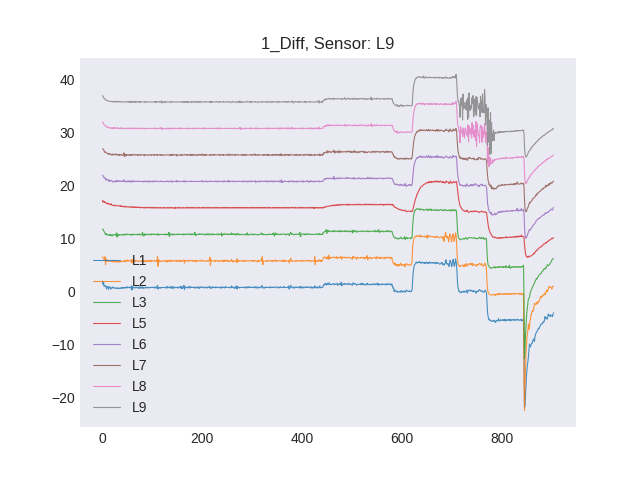

In [19]:
plot_multi_diff(x1, good_cols, '1_Diff')

## Time Series Function
This function examines different autoregression lags to see which have the most effect in the time series data. 


In [20]:
def tsplot(y, title=None, lags=None, figsize=(10, 8), style='bmh'):
    
    """  
    Basic time series analysis plots  
    
    Example:
    tsplot(np.diff(df2['L1']), lags=30, title='L1')
    
    Parameters
    ----------
    y : TYPE array
        DESCRIPTION. A diffed array of the time series data
    title : TYPE string, optional
        DESCRIPTION. Plot title. The default is None.
    lags : TYPE int, optional
        DESCRIPTION. number of lags to use in the autoregression. The default is None.
    figsize : TYPE, optional
        DESCRIPTION. The default is (15, 10).
    style : TYPE, optional
        DESCRIPTION. The default is 'bmh'.

    Returns
    -------
    None.

    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        fig.suptitle(title, fontsize=16)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        #plt.tight_layout()
    return 

<IPython.core.display.Javascript object>


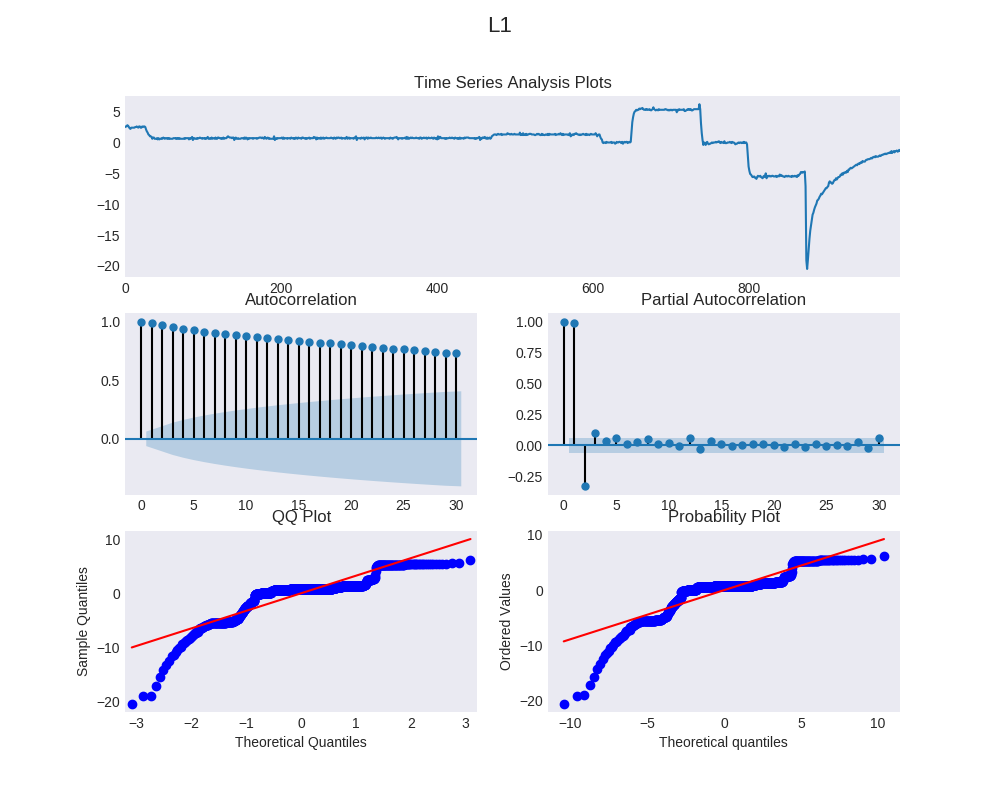

In [21]:
tsplot(np.diff(df2['L1']), lags=30, title='L1', style='seaborn-dark')